In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# %tensorflow_version 1.14
# !pip install q keras==1.2.2
# !pip install Keras-Applications

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

from sklearn.metrics import roc_auc_score

import numpy as np
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
# IMPORT KERAS LIBRARY
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

In [ ]:
tf.__version__

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:

# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

In [ ]:
# !kill -9 -1

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# !ls "/content/drive/My Drive/CheXpert-v1.0-small.zip"
# !unzip -uq "/content/drive/My Drive/data zip/CheXpert-v1.0-small.zip" -d "/content/drive/My Drive/dataset"


### Load configuration with local path and url for dataset

In [ ]:
model_path='.'
path='/content/drive/My Drive/dataset'
train_folder=f'{path}train'
test_folder=f'{path}test'
train_lbl=f'{path}train_labels.csv'

In [ ]:
chestxrays_root = Path(path)
data_path = chestxrays_root

### Load Data and the targets 

In [ ]:
!ls '/content/drive/My Drive/dataset'

CheXpert-v1.0-small


In [ ]:
full_train_df = pd.read_csv(data_path/'CheXpert-v1.0-small/train.csv')
full_valid_df = pd.read_csv(data_path/'CheXpert-v1.0-small/valid.csv')

In [ ]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [ ]:
full_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


### Uncertainty Approaches

The CheXpert paper outlines several different approaches to mapping using the uncertainty labels in the data:

- Ignoring - essentially removing from the calculation in the loss function
- Binary mapping - sending uncertain values to either 0 or 1
- Prevalence mapping - use the rate of prevelance of the feature as it's target value
- Self-training - consider the uncertain values as unlabeled
- 3-Class Classification - retain a separate value for uncertain and try to predict it as a class in its own right


The paper gives the results of different experiments with the above approaches and indicates the most accurate approach for each feature.
    
|Approach/Feature|Atelectasis|Cardiomegaly|Consolidation|Edema|PleuralEffusion|
|-----------|-----------|-----------|-----------|-----------|-----------|
|`U-Ignore`|0.818(0.759,0.877)|0.828(0.769,0.888)|0.938(0.905,0.970)|0.934(0.893,0.975)|0.928(0.894,0.962)|
|`U-Zeros`|0.811(0.751,0.872)|0.840(0.783,0.897)|0.932(0.898,0.966)|0.929(0.888,0.970)|0.931(0.897,0.965)|
|`U-Ones`|**0.858(0.806,0.910)**|0.832(0.773,0.890)|0.899(0.854,0.944)|0.941(0.903,0.980)|0.934(0.901,0.967)|
|`U-Mean`|0.821(0.762,0.879)|0.832(0.771,0.892)|0.937(0.905,0.969)|0.939(0.902,0.975)|0.930(0.896,0.965)|
|`U-SelfTrained`|0.833(0.776,0.890)|0.831(0.770,0.891)|0.939(0.908,0.971)|0.935(0.896,0.974)|0.932(0.899,0.966)|
|`U-MultiClass`|0.821(0.763,0.879)|**0.854(0.800,0.909)**|0.937(0.905,0.969)|0.928(0.887,0.968)|0.936(0.904,0.967)|

The binary mapping approaches (U-Ones and U-Zeros) are easiest to implement and so to begin with we take the best option between U-Ones and U-Zeros for each feature

- Atelectasis `U-Ones`
- Cardiomegaly `U-Zeros`
- Consolidation `U-Zeros`
- Edema `U-Ones`
- Pleural Effusion `U-Zeros`

In [ ]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

### Add target features string

In [ ]:
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        print("aa")
        print(row[feature])
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)
            
     

In [ ]:
full_train_df['train_valid'] = False
full_valid_df['train_valid'] = True
# full_train_df.Path.str.split('/',3,True)[3]

### Create patient and study columns

In [ ]:
full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
full_train_df  ['study'] = full_train_df.Path.str.split('/',4,True)[3]

full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]
full_valid_df  ['study'] = full_valid_df.Path.str.split('/',4,True)[3]

This is to get the number of study and the number of patient for each entry of the dataset

In [ ]:
full_df = pd.concat([full_train_df, full_valid_df])
# full_df.head()

Create a feature string containing all the classes and omiting the unknowns

In [ ]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

full_df['feature_string'] =full_df['feature_string'] .apply(lambda x:x.split(";"))
# full_df.head()

Streaming output truncated to the last 5000 lines.
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
-1.0
aa
nan
aa
nan
aa
1.0
aa
-1.0
aa
nan
aa
-1.0
aa
nan
aa
-1.0
aa
nan
aa
nan
aa
nan
aa
1.0
aa
0.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
-1.0
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
nan
aa
-1.0
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
1.0
aa
1.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
-1.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
nan
aa
1.0
aa
1.0
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
1.0
aa
-1.0
aa
1.0
aa
-1.0
aa
nan
aa
nan
aa
1.0
aa
1.0
aa
nan
aa
nan
aa
1.0
aa
nan
aa
1.0
aa
nan
aa
nan
aa
nan
aa
-1.0
aa
nan
aa
1.0
aa
1.0
aa
-1.0
aa
1.0
aa
0.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
-1.0
aa
0.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
nan
aa
nan
aa
-1.0
aa
nan
aa
nan
aa
1.0
aa
nan
aa
1.0
aa
nan
aa
0.0
aa
nan
aa
nan
aa
nan
aa
nan
aa
nan
aa
1.0
aa
nan
aa
1.0
aa
nan
aa
0.0
a

# Show some images

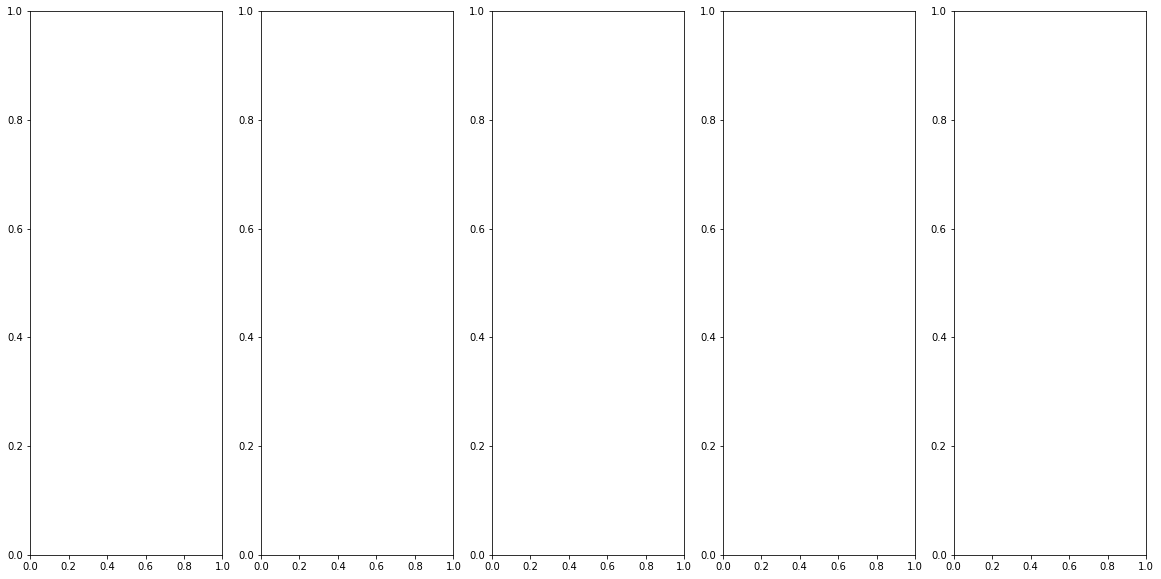

In [ ]:
#get the first 5 whale images
paths =  full_df.Path[:5]
labels = full_df.feature_string[:5]
# print(paths[:5])
# print(" hello ")
# print(labels)

fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
#show the images and label them
# for ii, c_ax in enumerate(m_axs):
#   # print(data_path)
#   print(os.path.join(data_path,paths[ii]))
#   print(cv2.imread(os.path.join(data_path,paths[ii])))
    # c_ax.imshow(cv2.imread(os.path.join(data_path,paths[ii])))
    # c_ax.set_title(labels[ii])

In [ ]:
from collections import Counter

labels_count = Counter(label for chexpert_targets in full_df['feature_string'] for label in chexpert_targets)
# plt.bar(chexpert_targets, labels_count.values(), align='center', alpha=0.5)
# plt.show
# print(labels_count)
x_pos = np.arange(len(labels_count.values()))
# print(x_pos)
#Plot the data:
my_colors = 'rgbkymc'
lbls = list.copy(chexpert_targets)
# print(lbls)
# lbls.insert(0,'')
# plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=my_colors)
# plt.xticks(x_pos, lbls, rotation='vertical')


## Set up the dataframe for training: 
* Separate the validation and the training samples
* Take a unique sample per patient
* Get a samle of 5% of the dataset

In [ ]:
sample_perc = 0.05
train_only_df = full_df[~full_df.train_valid]

# print("train")
# print(train_only_df.shape)

valid_only_df = full_df[full_df.train_valid]

# print("valid")
# print(valid_only_df.shape)

unique_patients = train_only_df.patient.unique()
# print(unique_patients)
# print(unique_patients.shape)
mask = np.random.rand(len(unique_patients)) <= sample_perc
print(mask)
sample_patients = unique_patients[mask]
print(sample_patients)
print(sample_patients.shape)

dev_df = train_only_df[full_train_df.patient.isin(sample_patients)]
train_df = train_only_df[~full_train_df.patient.isin(sample_patients)]

print(dev_df.shape)
print(valid_only_df.Path.size)
print(train_df.Path.size)

[False False False ... False False False]
['patient00016' 'patient00024' 'patient00054' ... 'patient64492'
 'patient64512' 'patient64516']
(3144,)
(10679, 23)
234
212735


# Set up data generation

In [ ]:
datagen=image.ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=5,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 validation_split = 0.1)
test_datagen=image.ImageDataGenerator(rescale=1./255)

In [ ]:
def generate_datasets(image_size = 224):
    print("1 start")
    train_generator=datagen.flow_from_dataframe(dataframe=train_df, directory=data_path, 
                                                x_col="Path", y_col="feature_string", has_ext=True, seed = 42, #classes = chexpert_targets,
                                                class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "training")
    print("1 done")
    validation_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=data_path, 
                                                       x_col="Path", y_col="feature_string", has_ext=True, seed = 42, #classes = chexpert_targets,
                                                       class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "validation")
    print("2 done")
    test_generator = test_datagen.flow_from_dataframe(dataframe=valid_only_df, directory=data_path, 
                                                      target_size=(image_size,image_size),class_mode='categorical',
                                                      batch_size=1, shuffle=False, #classes = chexpert_targets,
                                                      x_col="Path", y_col="feature_string")
    print("3 done")
    return [train_generator,validation_generator,test_generator]

# Build the model

Define the metrics

In [ ]:
def auc(y_true, y_pred):
    auc = tf.keras.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [ ]:
def define_model(image_size = 224, load_previous_weights = True, freeze_cnn = False):
    base_model = DenseNet121(include_top= False, input_shape=(image_size,image_size,3), weights='imagenet')
    # print(weights)
    

    # add a global spatial average pooling layer
    x = base_model.output
    # print(x)
    x = GlobalAveragePooling2D(input_shape=(1024,1,1))(x)
    # Add a flattern layer 
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # Add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # and a logistic layer --  we have 5 classes
    predictions = Dense(6, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Recover previously trained weights
    if load_previous_weights:
        try:
            model.load_weights('weights.hdf5')
            print('Weights successfuly loaded')
        except:
            print('Weights not loaded')

    # print("hello")
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    if freeze_cnn:
        for layer in base_model.layers:
            layer.trainable = False
    
    # print("hello")
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', auc])
        
    print("hello")
    return model

In [ ]:
def train_model(model , datasets, epochs=1, image_size = 224):
    
    checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                                   verbose=1, save_best_only=True)
    
    train_generator,validation_generator,test_generator = datasets
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    print(STEP_SIZE_TRAIN)
    print(STEP_SIZE_VALID)

    history = model.fit_generator(generator=train_generator,
                        # steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        # validation_steps=STEP_SIZE_VALID,
                        epochs=epochs, callbacks = [checkpointer])
    return history

In [ ]:
image_size_input = 224
model = define_model(image_size = image_size_input)

29089792/29084464 [==============================] - 0s 0us/step
Weights not loaded
hello


In [ ]:
datasets = generate_datasets(image_size = image_size_input)
train_generator,validation_generator,test_generator = datasets

1 start


In [ ]:
history = train_model(model , datasets, epochs=3, image_size = image_size_input)
history.history

In [ ]:
plt.figure(1)    
# summarize history for accuracy     
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss    
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
test = pd.Series(test_generator.labels)
mlb = MultiLabelBinarizer()
y_labels = mlb.fit_transform(test)

In [ ]:
test_generator.reset()
y_pred_keras = model.predict_generator(test_generator,verbose = 1,steps=test_generator.n)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

for ii in range(1, y_pred_keras.shape[1]):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels[:,ii], y_pred_keras[:,ii])
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label=chexpert_targets[ii-1] + '(area = {:.3f})'.format(auc_keras))
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
    



# Creating a Heatmap to visualize the classification output

In [ ]:
# get the first image of the testing dataset
x = test_generator[0][0]
preds = model.predict(x)

In [ ]:
preds = y_pred_keras[1,:]
class_idx = np.argmax(preds)
class_output = model.output[:, class_idx]
#import the last convolutional layer of the model, this depends on the model
last_conv_layer = model.get_layer("conv5_block16_concat")

In [ ]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(1024):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


In [ ]:
# Generate the heatmap
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [ ]:
img = x[0] 
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
img = np.uint8(255 * img)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [ ]:
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(superimposed_img)
plt.title("Heat map")